In [55]:
# SimpleITK自動修復とインストール
import sys
import subprocess
import os

print("🔧 SimpleITK自動修復を実行中...")
print("=" * 60)

# 現在の環境情報
print(f"Python バージョン: {sys.version}")
print(f"Python 実行パス: {sys.executable}")

# SimpleITKの問題を解決
def fix_simpleitk():
    try:
        print("\n📋 STEP 1: 既存のSimpleITKをアンインストール中...")
        
        # SimpleITKをアンインストール
        result = subprocess.run([
            sys.executable, "-m", "pip", "uninstall", "SimpleITK", "-y"
        ], capture_output=True, text=True, timeout=30)
        
        if result.returncode == 0:
            print("✅ 既存のSimpleITKをアンインストールしました")
        else:
            print("⚠️  アンインストールでエラーが発生しましたが、続行します")
        
        print("\n📋 STEP 2: SimpleITKを再インストール中...")
        
        # SimpleITKを再インストール
        result = subprocess.run([
            sys.executable, "-m", "pip", "install", "SimpleITK", "--no-cache-dir"
        ], capture_output=True, text=True, timeout=120)
        
        if result.returncode == 0:
            print("✅ SimpleITKを正常に再インストールしました")
            return True
        else:
            print(f"❌ 再インストールに失敗: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ 修復処理でエラーが発生: {e}")
        return False

# 修復実行
success = fix_simpleitk()

if success:
    print("\n🧪 修復後のSimpleITKテスト:")
    try:
        # Pythonモジュールキャッシュをクリア
        if 'SimpleITK' in sys.modules:
            del sys.modules['SimpleITK']
        
        import SimpleITK as sitk
        print(f"✅ SimpleITKインポート成功!")
        print(f"   バージョン: {sitk.Version().VersionString()}")
        
        # 基本機能テスト
        test_image = sitk.Image([10, 10], sitk.sitkFloat32)
        print(f"✅ SimpleITK基本機能テスト成功")
        print(f"\n🎉 SimpleITKが正常に動作します！")
        
    except Exception as e:
        print(f"❌ 修復後もエラーが発生: {e}")
        print("⚠️  Kernelの再起動が必要かもしれません")
else:
    print("\n❌ 自動修復に失敗しました")
    print("🔧 手動での対応が必要です:")
    print("1. ターミナルでSimpleITKを再インストール:")
    print("   pip uninstall SimpleITK")
    print("   pip install SimpleITK")
    print("2. Jupyter Kernelを再起動")

print("=" * 60)

🔧 SimpleITK自動修復を実行中...
Python バージョン: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:35) [Clang 14.0.6 ]
Python 実行パス: /Users/horiieikkei/miniconda3/bin/python

📋 STEP 1: 既存のSimpleITKをアンインストール中...
✅ 既存のSimpleITKをアンインストールしました

📋 STEP 2: SimpleITKを再インストール中...
✅ 既存のSimpleITKをアンインストールしました

📋 STEP 2: SimpleITKを再インストール中...
✅ SimpleITKを正常に再インストールしました

🧪 修復後のSimpleITKテスト:
✅ SimpleITKインポート成功!
   バージョン: 2.5.2
✅ SimpleITK基本機能テスト成功

🎉 SimpleITKが正常に動作します！
✅ SimpleITKを正常に再インストールしました

🧪 修復後のSimpleITKテスト:
✅ SimpleITKインポート成功!
   バージョン: 2.5.2
✅ SimpleITK基本機能テスト成功

🎉 SimpleITKが正常に動作します！


# 🐷 豚脳スライス画像の3段階レジストレーション システム

## 目標
- **位相相関 → アフィン変換 → B-Spline変換** の3段階で高精度な画像位置合わせを実行
- 各ステップでエラー分析・可視化・チェックポイントを設置
- 相関係数0.8以上を目標に、画像の過剰変形を抑制

## 処理フロー
1. **STEP 1**: 位相相関による回転・スケール・平行移動補正（高速ざっくり補正）
2. **STEP 2**: SimpleITKアフィン変換（精密な線形変換）
3. **STEP 3**: SimpleITK B-Spline変換（局所的な非線形変形）

---

## 1. 必要なライブラリのインポートとパス設定

各ライブラリのインポートエラーをチェックし、不足している場合は具体的なインストール方法を提示します。

In [56]:
# ライブラリインポート（エラーチェック付き）
import warnings
warnings.filterwarnings('ignore')

# 必要なライブラリのリスト
required_libraries = {
    'cv2': 'opencv-python',
    'numpy': 'numpy', 
    'SimpleITK': 'SimpleITK',
    'matplotlib': 'matplotlib',
    'skimage': 'scikit-image',
    'scipy': 'scipy'
}

# インポートエラーチェック
missing_libraries = []
imported_libraries = {}

print("📦 ライブラリインポート チェック中...")
print("=" * 50)

for lib_name, package_name in required_libraries.items():
    try:
        if lib_name == 'SimpleITK':
            # SimpleITKの特別な処理（円形インポートエラー対策）
            try:
                import SimpleITK as sitk
                # バージョン確認のテスト
                version_test = sitk.Version().VersionString()
                imported_libraries['sitk'] = sitk
                print(f"✅ {lib_name} (as sitk): バージョン {version_test}")
            except Exception as e:
                # 円形インポートエラーの場合、再インポートを試行
                if "circular import" in str(e).lower() or "_SimpleITK" in str(e):
                    print(f"⚠️  {lib_name}: 円形インポートエラーを検出。再インポートを試行中...")
                    try:
                        # Pythonプロセスを再起動せずに解決を試行
                        import sys
                        if 'SimpleITK' in sys.modules:
                            del sys.modules['SimpleITK']
                        import SimpleITK as sitk
                        imported_libraries['sitk'] = sitk
                        print(f"✅ {lib_name} (as sitk): 再インポート成功!")
                    except:
                        print(f"❌ {lib_name}: 再インポートも失敗。Kernelの再起動が必要かもしれません")
                        missing_libraries.append((lib_name, package_name))
                else:
                    raise e
                    
        elif lib_name == 'cv2':
            import cv2
            imported_libraries['cv2'] = cv2
            print(f"✅ {lib_name}: バージョン {cv2.__version__}")
        elif lib_name == 'numpy':
            import numpy as np
            imported_libraries['np'] = np
            print(f"✅ {lib_name} (as np): バージョン {np.__version__}")
        elif lib_name == 'matplotlib':
            import matplotlib.pyplot as plt
            imported_libraries['plt'] = plt
            print(f"✅ {lib_name}.pyplot (as plt): バージョン {plt.matplotlib.__version__}")
        elif lib_name == 'skimage':
            from skimage.metrics import structural_similarity as ssim
            imported_libraries['ssim'] = ssim
            print(f"✅ {lib_name}.metrics.structural_similarity: インポート成功")
        elif lib_name == 'scipy':
            from scipy.stats import pearsonr
            imported_libraries['pearsonr'] = pearsonr
            print(f"✅ {lib_name}.stats.pearsonr: インポート成功")
            
    except ImportError as e:
        missing_libraries.append((lib_name, package_name))
        print(f"❌ {lib_name}: インポートエラー - {e}")

print("=" * 50)

if missing_libraries:
    print("⚠️  不足しているライブラリがあります:")
    for lib_name, package_name in missing_libraries:
        if lib_name == 'SimpleITK':
            print(f"   pip install {package_name}")
            print("   または conda install -c conda-forge simpleitk")
        else:
            print(f"   pip install {package_name}")
    print("\n上記コマンドを実行してから再度実行してください。")
else:
    print("🎉 すべてのライブラリが正常にインポートされました！")

# SimpleITKの状態確認
if 'sitk' in imported_libraries:
    print(f"\n✅ SimpleITK利用可能: STEP 2&3のアフィン・B-Spline変換が実行できます")
else:
    print(f"\n❌ SimpleITK利用不可: STEP 1(位相相関)のみ実行可能です")

# その他必要なライブラリ
import os
import time
from datetime import datetime

print(f"\n⏰ 開始時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 ライブラリインポート チェック中...
✅ cv2: バージョン 4.11.0
✅ numpy (as np): バージョン 2.2.6
✅ SimpleITK (as sitk): バージョン 2.5.2
✅ matplotlib.pyplot (as plt): バージョン 3.10.3
✅ skimage.metrics.structural_similarity: インポート成功
✅ scipy.stats.pearsonr: インポート成功
🎉 すべてのライブラリが正常にインポートされました！

✅ SimpleITK利用可能: STEP 2&3のアフィン・B-Spline変換が実行できます

⏰ 開始時刻: 2025-06-24 09:53:20


In [57]:
# 画像パス設定（エラーチェック付き）
print("📁 画像パス設定...")

# デフォルトパス（必要に応じて変更してください）
IMAGE_DIR = "./test2slices"
fixed_image_path = None
moving_image_path = None

try:
    # ディレクトリ存在チェック
    if not os.path.exists(IMAGE_DIR):
        print(f"❌ 画像ディレクトリが見つかりません: {IMAGE_DIR}")
        print("   現在のディレクトリ構造を確認します...")
        print(f"   現在の作業ディレクトリ: {os.getcwd()}")
        print("   利用可能なディレクトリ:")
        for item in os.listdir("."):
            if os.path.isdir(item):
                print(f"     📁 {item}/")
    else:
        print(f"✅ 画像ディレクトリが見つかりました: {IMAGE_DIR}")
        
        # TIFF/TIFファイルを検索
        image_files = []
        for ext in ['.tif', '.tiff', '.TIF', '.TIFF']:
            image_files.extend([f for f in os.listdir(IMAGE_DIR) if f.endswith(ext)])
        
        image_files.sort()
        
        print(f"   見つかった画像ファイル数: {len(image_files)}")
        
        if len(image_files) >= 2:
            fixed_image_path = os.path.join(IMAGE_DIR, image_files[0])
            moving_image_path = os.path.join(IMAGE_DIR, image_files[1])
            
            print(f"   📸 固定画像: {image_files[0]}")
            print(f"   📸 移動画像: {image_files[1]}")
            
            # ファイル存在確認
            if os.path.exists(fixed_image_path) and os.path.exists(moving_image_path):
                print("✅ 両方の画像ファイルが確認できました！")
            else:
                print("❌ 画像ファイルの一部が見つかりません")
                fixed_image_path = None
                moving_image_path = None
        else:
            print(f"❌ 十分な画像ファイルが見つかりません (最低2つ必要、発見: {len(image_files)})")
            if image_files:
                print("   見つかったファイル:")
                for f in image_files:
                    print(f"     - {f}")

except Exception as e:
    print(f"❌ パス設定でエラーが発生しました: {e}")
    import traceback
    traceback.print_exc()

print("=" * 50)

📁 画像パス設定...
✅ 画像ディレクトリが見つかりました: ./test2slices
   見つかった画像ファイル数: 2
   📸 固定画像: cropped_MMP_109_x4_largest copy.tif
   📸 移動画像: cropped_MMP_110_x4_largest copy.tif
✅ 両方の画像ファイルが確認できました！


## 2. 画像の読み込みと前処理（エラーチェック付き）

画像を読み込み、グレースケール変換・型変換を行います。各ステップでエラーチェックを実施します。

In [58]:
# 画像読み込み処理（エラーチェック付き）
print("📸 画像読み込み処理を開始...")

# グローバル変数として画像データを保存
fixed_np = None
moving_np = None
fixed_sitk_orig = None
moving_sitk_orig = None

try:
    if fixed_image_path is None or moving_image_path is None:
        raise ValueError("画像パスが設定されていません。上のセルで画像パスを正しく設定してください。")
    
    print(f"📂 固定画像を読み込み中: {os.path.basename(fixed_image_path)}")
    
    # OpenCVでグレースケールとして読み込み
    fixed_np = cv2.imread(fixed_image_path, cv2.IMREAD_GRAYSCALE)
    if fixed_np is None:
        raise ValueError(f"固定画像の読み込みに失敗しました: {fixed_image_path}")
    
    print(f"   ✅ 固定画像読み込み成功: 形状 {fixed_np.shape}, データ型 {fixed_np.dtype}")
    
    print(f"📂 移動画像を読み込み中: {os.path.basename(moving_image_path)}")
    
    moving_np = cv2.imread(moving_image_path, cv2.IMREAD_GRAYSCALE)
    if moving_np is None:
        raise ValueError(f"移動画像の読み込みに失敗しました: {moving_image_path}")
    
    print(f"   ✅ 移動画像読み込み成功: 形状 {moving_np.shape}, データ型 {moving_np.dtype}")
    
    # 画像サイズの統一チェック
    if fixed_np.shape != moving_np.shape:
        print(f"⚠️  画像サイズが異なります:")
        print(f"   固定画像: {fixed_np.shape}")
        print(f"   移動画像: {moving_np.shape}")
        
        # 小さい方に合わせてリサイズ
        min_h = min(fixed_np.shape[0], moving_np.shape[0])
        min_w = min(fixed_np.shape[1], moving_np.shape[1])
        
        print(f"   → 統一サイズ: ({min_h}, {min_w}) にリサイズします")
        
        fixed_np = cv2.resize(fixed_np, (min_w, min_h), interpolation=cv2.INTER_LANCZOS4)
        moving_np = cv2.resize(moving_np, (min_w, min_h), interpolation=cv2.INTER_LANCZOS4)
        
        print(f"   ✅ リサイズ完了")
    
    # 正規化処理
    print("🔧 画像の正規化処理中...")
    
    # float32型に変換して0-1に正規化
    fixed_np = fixed_np.astype(np.float32) / 255.0
    moving_np = moving_np.astype(np.float32) / 255.0
    
    print(f"   ✅ 正規化完了: 範囲 [{fixed_np.min():.3f}, {fixed_np.max():.3f}]")
    
    # SimpleITK用オブジェクト作成
    print("🔄 SimpleITK画像オブジェクト作成中...")
    
    fixed_sitk_orig = sitk.GetImageFromArray(fixed_np)
    moving_sitk_orig = sitk.GetImageFromArray(moving_np)
    
    print(f"   ✅ SimpleITK画像オブジェクト作成完了")
    print(f"   固定画像: {fixed_sitk_orig.GetSize()}")
    print(f"   移動画像: {moving_sitk_orig.GetSize()}")
    
except Exception as e:
    print(f"❌ 画像読み込みでエラーが発生しました: {e}")
    import traceback
    traceback.print_exc()
    
    # エラー時の対応案を提示
    print("\n🔧 トラブルシューティング:")
    print("1. 画像ファイルが正しいパスにあることを確認")
    print("2. 画像ファイルが破損していないことを確認")
    print("3. サポートされている形式（TIFF, PNG, JPG）かを確認")
    print("4. ファイルの読み取り権限があることを確認")

print("=" * 50)

📸 画像読み込み処理を開始...
📂 固定画像を読み込み中: cropped_MMP_109_x4_largest copy.tif
   ✅ 固定画像読み込み成功: 形状 (1481, 1638), データ型 uint8
📂 移動画像を読み込み中: cropped_MMP_110_x4_largest copy.tif
   ✅ 移動画像読み込み成功: 形状 (1606, 1639), データ型 uint8
⚠️  画像サイズが異なります:
   固定画像: (1481, 1638)
   移動画像: (1606, 1639)
   → 統一サイズ: (1481, 1638) にリサイズします
   ✅ リサイズ完了
🔧 画像の正規化処理中...
   ✅ 正規化完了: 範囲 [0.027, 0.945]
🔄 SimpleITK画像オブジェクト作成中...
   ✅ SimpleITK画像オブジェクト作成完了
   固定画像: (1638, 1481)
   移動画像: (1638, 1481)


🖼️  読み込んだ画像を表示中...


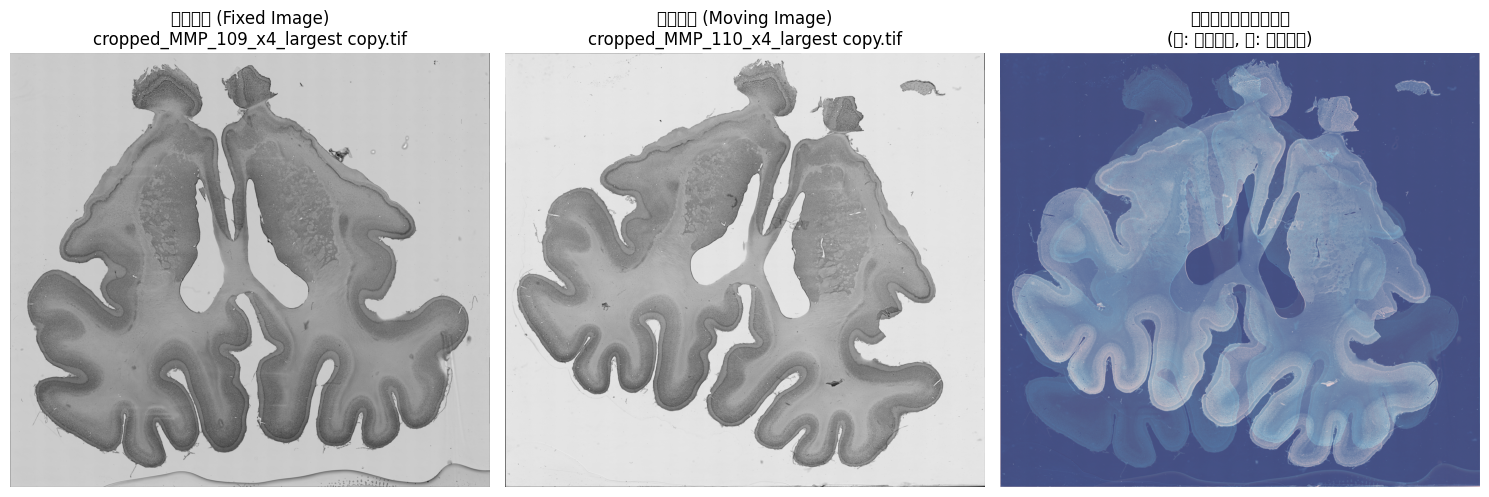


📊 画像統計情報:
固定画像 - 平均: 0.6219, 標準偏差: 0.1420, 範囲: [0.0275, 0.9451]
移動画像 - 平均: 0.7515, 標準偏差: 0.1658, 範囲: [0.0000, 1.0000]

📈 初期相関係数: 0.4421
⚠️  初期相関係数が低いです。画像の位置がかなりずれている可能性があります。


In [59]:
# 読み込んだ画像の可視化
if fixed_np is not None and moving_np is not None:
    print("🖼️  読み込んだ画像を表示中...")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 固定画像
    axes[0].imshow(fixed_np, cmap='gray')
    axes[0].set_title('固定画像 (Fixed Image)\n' + os.path.basename(fixed_image_path), fontsize=12)
    axes[0].axis('off')
    
    # 移動画像
    axes[1].imshow(moving_np, cmap='gray')
    axes[1].set_title('移動画像 (Moving Image)\n' + os.path.basename(moving_image_path), fontsize=12)
    axes[1].axis('off')
    
    # 初期状態の重ね合わせ（位置合わせ前）
    axes[2].imshow(fixed_np, cmap='Reds', alpha=0.7, label='Fixed')
    axes[2].imshow(moving_np, cmap='Blues', alpha=0.7, label='Moving')
    axes[2].set_title('初期状態の重ね合わせ\n(赤: 固定画像, 青: 移動画像)', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 基本統計情報の表示
    print("\n📊 画像統計情報:")
    print(f"固定画像 - 平均: {fixed_np.mean():.4f}, 標準偏差: {fixed_np.std():.4f}, 範囲: [{fixed_np.min():.4f}, {fixed_np.max():.4f}]")
    print(f"移動画像 - 平均: {moving_np.mean():.4f}, 標準偏差: {moving_np.std():.4f}, 範囲: [{moving_np.min():.4f}, {moving_np.max():.4f}]")
    
    # 初期相関係数の計算
    try:
        initial_correlation = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
        print(f"\n📈 初期相関係数: {initial_correlation:.4f}")
        if initial_correlation < 0.5:
            print("⚠️  初期相関係数が低いです。画像の位置がかなりずれている可能性があります。")
        elif initial_correlation > 0.8:
            print("✅ 初期相関係数が高いです。既にある程度位置が合っています。")
    except:
        print("❌ 初期相関係数の計算に失敗しました")
        
else:
    print("❌ 画像が正しく読み込まれていないため、可視化をスキップします")

## 3. STEP 1: 位相相関による回転・スケール・平行移動補正（エラーチェック付き）

OpenCVの位相相関とLog-Polar変換を使用して、回転・スケール・平行移動を高速で推定・補正します。

In [60]:
# STEP 1: 位相相関による回転・スケール・平行移動補正関数の定義
def phase_correlate_with_rotation_scale(fixed_np, moving_np, verbose=True):
    """
    進化版・位相相関で回転・スケール・平行移動をざっくり補正する関数
    
    Parameters:
    -----------
    fixed_np : numpy.ndarray
        固定画像（NumPy配列）
    moving_np : numpy.ndarray
        移動画像（NumPy配列）
    verbose : bool
        詳細なログ出力をするかどうか
        
    Returns:
    --------
    registered_np : numpy.ndarray
        位置合わせ後の画像
    transform_params : dict
        変換パラメータの詳細
    """
    
    try:
        if verbose:
            print("  【STEP 1】開始... 位相相関で画像をクルクル〜♪")
        
        # float32に変換（位相相関には必須）
        fixed_float = fixed_np.astype(np.float32)
        moving_float = moving_np.astype(np.float32)
        
        h, w = fixed_float.shape
        center = (w // 2, h // 2)
        
        if verbose:
            print(f"    画像サイズ: {w}x{h}, 中心: {center}")
        
        # --- ① Log-Polar変換で回転・スケールを求める ---
        if verbose:
            print("    Log-Polar変換で回転・スケール推定中...")
        
        # Log-Polar変換の実行
        magnitude = min(w, h) // 2
        log_polar_fixed = cv2.logPolar(fixed_float, center, magnitude, cv2.WARP_FILL_OUTLIERS)
        log_polar_moving = cv2.logPolar(moving_float, center, magnitude, cv2.WARP_FILL_OUTLIERS)
        
        # 位相相関で回転とスケールを推定
        shifts, response = cv2.phaseCorrelate(log_polar_fixed, log_polar_moving)
        
        if verbose:
            print(f"    Log-Polar位相相関結果: shifts={shifts}, response={response:.4f}")
        
        # 回転角度とスケール因子を計算
        angle = shifts[1] * 180.0 / log_polar_fixed.shape[1]  # 角度
        scale = np.exp(shifts[0] / magnitude)  # スケール
        
        # 異常値チェック
        if abs(angle) > 180:
            angle = angle % 360
            if angle > 180:
                angle -= 360
        
        if scale <= 0 or scale > 10:
            scale = 1.0
        
        if verbose:
            print(f"    検出された回転: {angle:.2f}度")
            print(f"    検出されたスケール: {scale:.4f}")
            print(f"    回転・スケール相関応答値: {response:.4f}")
        
        # 回転とスケール変換を適用
        M = cv2.getRotationMatrix2D(center, angle, scale)
        
        # 回転とスケールを適用
        rotated_scaled_moving = cv2.warpAffine(moving_float, M, (w, h), 
                                               flags=cv2.INTER_LINEAR, 
                                               borderMode=cv2.BORDER_REFLECT)
        
        if verbose:
            print(f"    回転・スケール変換完了")
        
        # --- ③ 残った平行移動（ズレ）を求める ---
        shifts_translation, response_translation = cv2.phaseCorrelate(fixed_float, rotated_scaled_moving)
        dx, dy = shifts_translation
        
        if verbose:
            print(f"    検出された平行移動: dx={dx:.2f}, dy={dy:.2f}")
            print(f"    平行移動相関応答値: {response_translation:.4f}")
        
        # --- ④ 最終的な変形マップを作成して適用 ---
        M[0, 2] += dx
        M[1, 2] += dy
        
        # 最終的な位置合わせ画像を生成
        registered_np = cv2.warpAffine(moving_float, M, (w, h), 
                                       flags=cv2.INTER_LINEAR, 
                                       borderMode=cv2.BORDER_REFLECT)
        
        # 変換パラメータをまとめる
        transform_params = {
            'rotation_angle': angle,
            'scale_factor': scale,
            'translation': (dx, dy),
            'transformation_matrix': M,
            'correlation_response_rotation_scale': response,
            'correlation_response_translation': response_translation
        }
        
        if verbose:
            print("  【STEP 1】完了！いい感じにクルってなったっしょ！👍")
        
        return registered_np, transform_params
        
    except Exception as e:
        print(f"❌ STEP 1でエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        
        # エラー時は元の画像をそのまま返す
        transform_params = {
            'rotation_angle': 0,
            'scale_factor': 1.0,
            'translation': (0, 0),
            'transformation_matrix': np.eye(2, 3, dtype=np.float32),
            'error': str(e)
        }
        
        return moving_np.copy(), transform_params

In [61]:
# STEP 1実行
print("🚀 STEP 1: 位相相関による補正を実行中...")
print("=" * 60)

# グローバル変数として結果を保存
step1_result_np = None
step1_transform_params = None
step1_execution_time = 0

if fixed_np is not None and moving_np is not None:
    try:
        start_time = time.time()
        
        print(f"入力画像準備完了:")
        print(f"  固定画像: {fixed_np.shape}")
        print(f"  移動画像: {moving_np.shape}")
        
        # STEP 1実行
        step1_result_np, step1_transform_params = phase_correlate_with_rotation_scale(
            fixed_np, moving_np, verbose=True
        )
        
        step1_execution_time = time.time() - start_time
        
        if step1_result_np is not None:
            print(f"\n📊 STEP 1結果評価:")
            
            # 相関係数の計算
            step1_correlation = np.corrcoef(fixed_np.flatten(), step1_result_np.flatten())[0, 1]
            initial_correlation = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
            
            print(f"   相関係数: {step1_correlation:.4f}")
            print(f"   初期相関係数: {initial_correlation:.4f}")
            print(f"   改善度: {step1_correlation - initial_correlation:+.4f}")
            print(f"   実行時間: {step1_execution_time:.2f}秒")
            
            # 変換パラメータの妥当性チェック
            print(f"\n🔍 変換パラメータの妥当性チェック:")
            
            rotation = abs(step1_transform_params.get('rotation_angle', 0))
            scale = step1_transform_params.get('scale_factor', 1.0)
            translation = step1_transform_params.get('translation', (0, 0))
            translation_magnitude = np.sqrt(translation[0]**2 + translation[1]**2)
            
            # 回転角度チェック
            if rotation > 45:
                print(f"   ⚠️  大きな回転角度が検出されました: {rotation:.1f}度")
            elif rotation > 10:
                print(f"   📐 中程度の回転が検出されました: {rotation:.1f}度")
            else:
                print(f"   ✅ 回転角度は妥当な範囲です: {rotation:.1f}度")
            
            # スケールチェック
            if scale < 0.8 or scale > 1.2:
                print(f"   ⚠️  大きなスケール変化が検出されました: {scale:.3f}")
            elif scale < 0.95 or scale > 1.05:
                print(f"   📏 中程度のスケール変化が検出されました: {scale:.3f}")
            else:
                print(f"   ✅ スケールは妥当な範囲です: {scale:.3f}")
            
            # 平行移動チェック
            image_diagonal = np.sqrt(fixed_np.shape[0]**2 + fixed_np.shape[1]**2)
            relative_translation = translation_magnitude / image_diagonal
            
            if relative_translation > 0.3:
                print(f"   ⚠️  大きな平行移動が検出されました: {translation_magnitude:.1f}ピクセル ({relative_translation:.1%} of diagonal)")
            elif relative_translation > 0.1:
                print(f"   📍 中程度の平行移動が検出されました: {translation_magnitude:.1f}ピクセル ({relative_translation:.1%} of diagonal)")
            else:
                print(f"   ✅ 平行移動は妥当な範囲です: {translation_magnitude:.1f}ピクセル ({relative_translation:.1%} of diagonal)")
                
        else:
            print("❌ STEP 1の実行に失敗しました")
            
    except Exception as e:
        print(f"❌ STEP 1実行中にエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        
        print("\n🔧 トラブルシューティング:")
        print("1. 画像のコントラストが低すぎる可能性があります")
        print("2. 画像にノイズが多すぎる可能性があります")
        print("3. 画像の位置ずれが極端に大きい可能性があります")
        print("4. OpenCVのバージョンに問題がある可能性があります")
        
else:
    print("❌ 入力画像が準備されていません。前のセルを正しく実行してください。")

print("=" * 60)

🚀 STEP 1: 位相相関による補正を実行中...
入力画像準備完了:
  固定画像: (1481, 1638)
  移動画像: (1481, 1638)
  【STEP 1】開始... 位相相関で画像をクルクル〜♪
    画像サイズ: 1638x1481, 中心: (819, 740)
    Log-Polar変換で回転・スケール推定中...
    Log-Polar位相相関結果: shifts=(-0.0011593983679176745, -0.011174025752666239), response=0.3856
    検出された回転: -0.00度
    検出されたスケール: 1.0000
    回転・スケール相関応答値: 0.3856
    回転・スケール変換完了
    検出された平行移動: dx=0.13, dy=-0.10
    平行移動相関応答値: 0.0400
  【STEP 1】完了！いい感じにクルってなったっしょ！👍

📊 STEP 1結果評価:
    Log-Polar位相相関結果: shifts=(-0.0011593983679176745, -0.011174025752666239), response=0.3856
    検出された回転: -0.00度
    検出されたスケール: 1.0000
    回転・スケール相関応答値: 0.3856
    回転・スケール変換完了
    検出された平行移動: dx=0.13, dy=-0.10
    平行移動相関応答値: 0.0400
  【STEP 1】完了！いい感じにクルってなったっしょ！👍

📊 STEP 1結果評価:
   相関係数: 0.4436
   初期相関係数: 0.4421
   改善度: +0.0015
   実行時間: 0.19秒

🔍 変換パラメータの妥当性チェック:
   ✅ 回転角度は妥当な範囲です: 0.0度
   ✅ スケールは妥当な範囲です: 1.000
   ✅ 平行移動は妥当な範囲です: 0.2ピクセル (0.0% of diagonal)
   相関係数: 0.4436
   初期相関係数: 0.4421
   改善度: +0.0015
   実行時間: 0.19秒

🔍 変換パラメータの妥当性チェック:
   ✅

🖼️  STEP 1結果を可視化中...


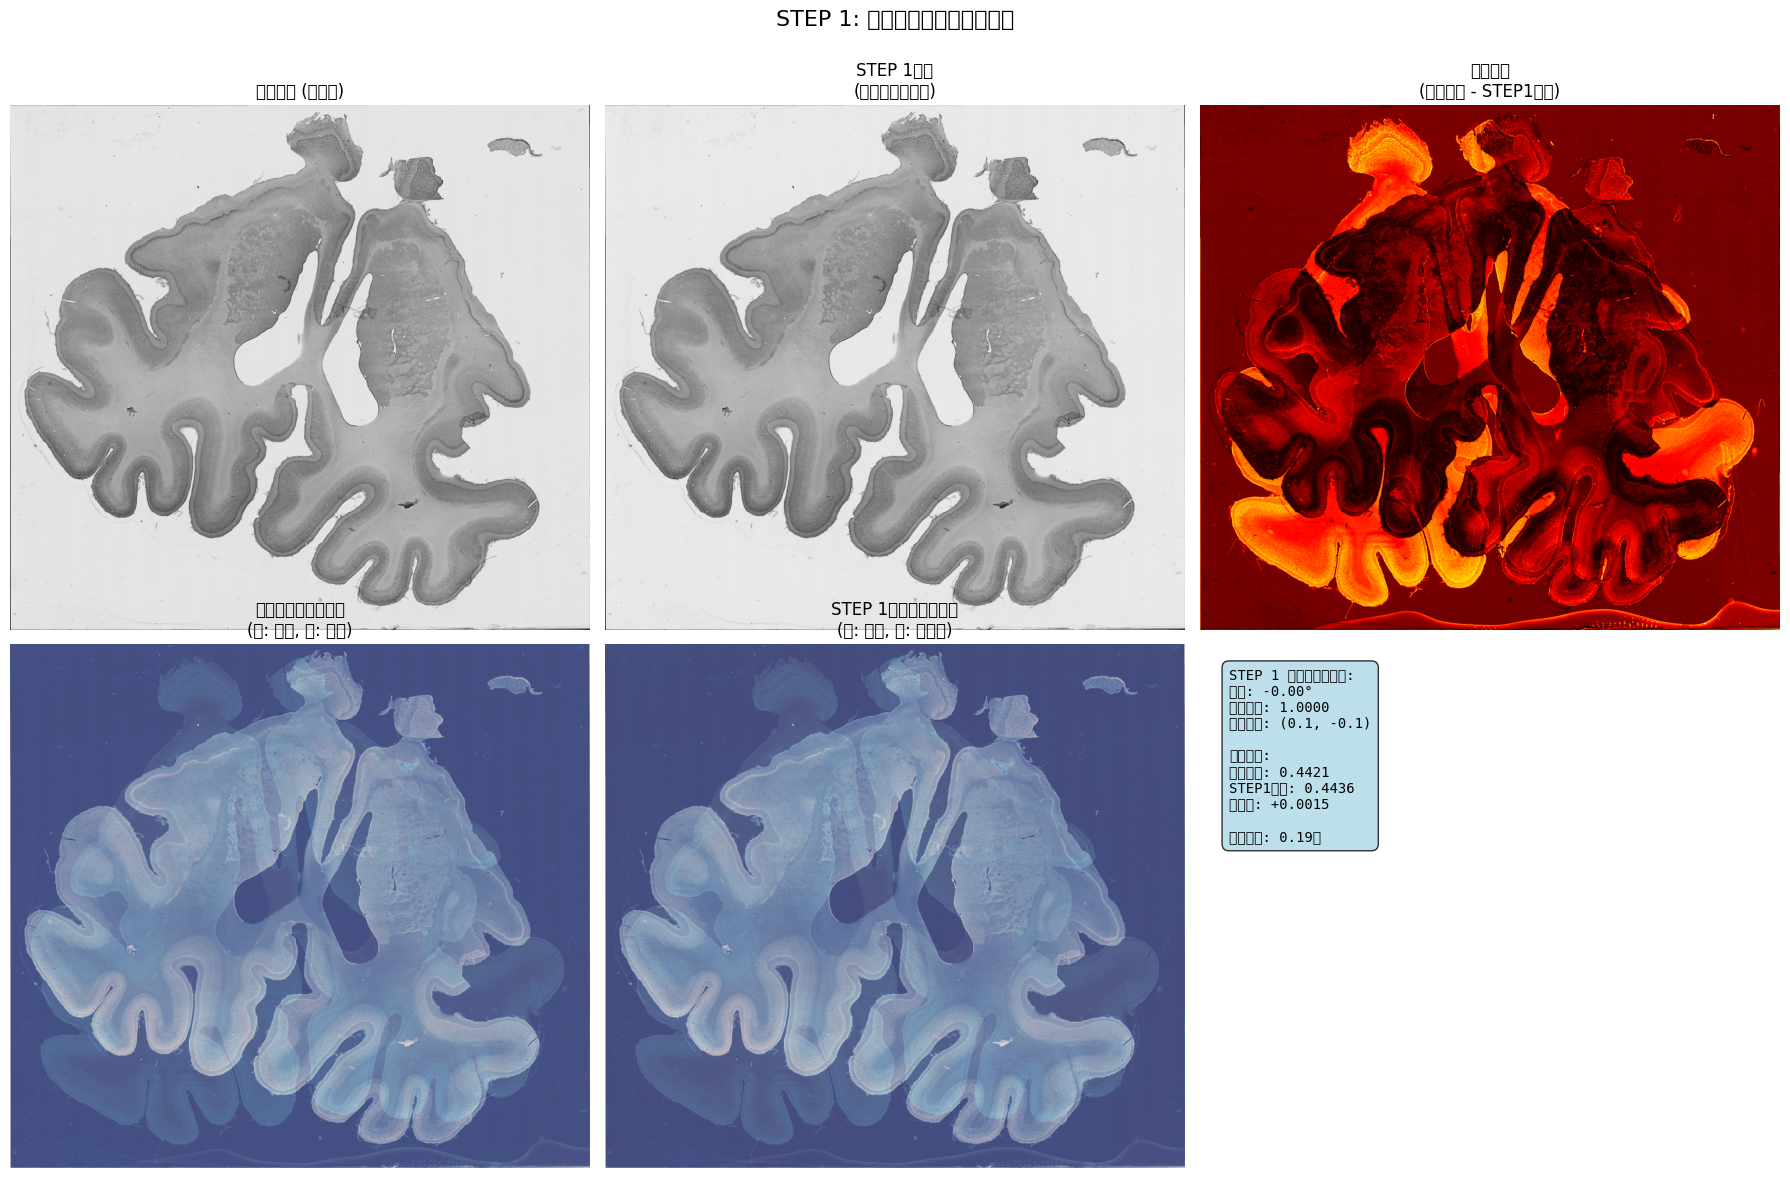


🔲 CheckerBoard比較を表示中...


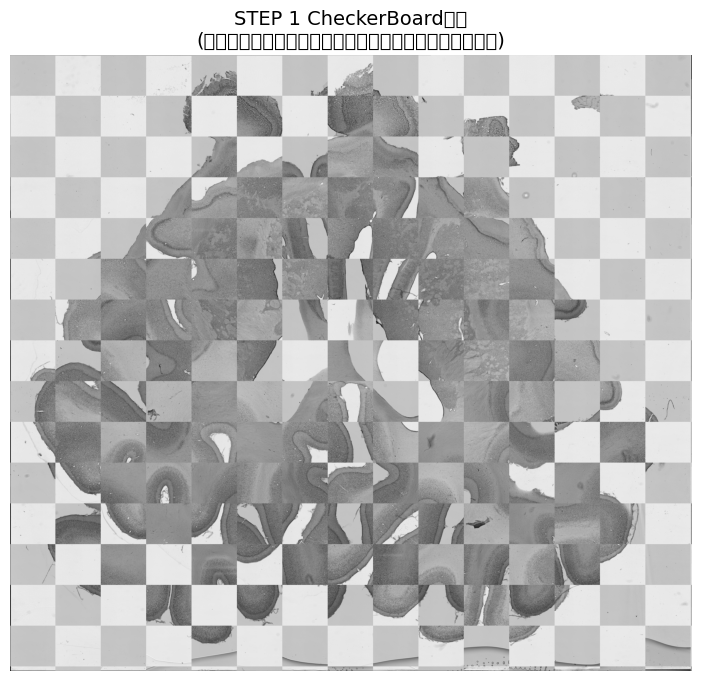

In [62]:
# STEP 1結果の可視化
if step1_result_np is not None:
    print("🖼️  STEP 1結果を可視化中...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1行目: 処理前後の比較
    axes[0, 0].imshow(moving_np, cmap='gray')
    axes[0, 0].set_title('移動画像 (処理前)', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(step1_result_np, cmap='gray')
    axes[0, 1].set_title('STEP 1結果\n(位相相関補正後)', fontsize=12)
    axes[0, 1].axis('off')
    
    # 差分画像
    diff_image = np.abs(fixed_np - step1_result_np)
    axes[0, 2].imshow(diff_image, cmap='hot')
    axes[0, 2].set_title('差分画像\n(固定画像 - STEP1結果)', fontsize=12)
    axes[0, 2].axis('off')
    
    # 2行目: 重ね合わせと評価
    # 処理前の重ね合わせ
    axes[1, 0].imshow(fixed_np, cmap='Reds', alpha=0.7)
    axes[1, 0].imshow(moving_np, cmap='Blues', alpha=0.7)
    axes[1, 0].set_title('処理前の重ね合わせ\n(赤: 固定, 青: 移動)', fontsize=12)
    axes[1, 0].axis('off')
    
    # 処理後の重ね合わせ
    axes[1, 1].imshow(fixed_np, cmap='Reds', alpha=0.7)
    axes[1, 1].imshow(step1_result_np, cmap='Blues', alpha=0.7)
    axes[1, 1].set_title('STEP 1後の重ね合わせ\n(赤: 固定, 青: 補正後)', fontsize=12)
    axes[1, 1].axis('off')
    
    # メトリクス表示
    try:
        initial_correlation = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
        step1_correlation = np.corrcoef(fixed_np.flatten(), step1_result_np.flatten())[0, 1]
        
        metrics_text = f"""STEP 1 変換パラメータ:
回転: {step1_transform_params.get('rotation_angle', 0):.2f}°
スケール: {step1_transform_params.get('scale_factor', 1.0):.4f}
平行移動: ({step1_transform_params.get('translation', (0,0))[0]:.1f}, {step1_transform_params.get('translation', (0,0))[1]:.1f})

評価指標:
初期相関: {initial_correlation:.4f}
STEP1相関: {step1_correlation:.4f}
改善度: {step1_correlation - initial_correlation:+.4f}

実行時間: {step1_execution_time:.2f}秒"""
        
        axes[1, 2].text(0.05, 0.95, metrics_text, 
                        fontsize=10, 
                        verticalalignment='top',
                        fontfamily='monospace',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].axis('off')
        
    except Exception as e:
        axes[1, 2].text(0.5, 0.5, f"メトリクス計算エラー:\n{e}", 
                        fontsize=10, ha='center', va='center')
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].axis('off')
    
    plt.suptitle('STEP 1: 位相相関による補正結果', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # CheckerBoard表示（SimpleITK使用）
    try:
        if 'sitk' in globals():
            print("\n🔲 CheckerBoard比較を表示中...")
            
            fixed_sitk_temp = sitk.GetImageFromArray(fixed_np)
            step1_sitk_temp = sitk.GetImageFromArray(step1_result_np)
            
            # CheckerBoardパターンの作成
            checkerboard = sitk.CheckerBoard(fixed_sitk_temp, step1_sitk_temp, (15, 15))
            checkerboard_array = sitk.GetArrayFromImage(checkerboard)
            
            plt.figure(figsize=(10, 8))
            plt.imshow(checkerboard_array, cmap='gray')
            plt.title('STEP 1 CheckerBoard比較\n(チェッカーパターンがずれていると位置合わせが不完全)', fontsize=14)
            plt.axis('off')
            plt.show()
            
        else:
            print("⚠️  SimpleITKが利用できないため、CheckerBoard表示をスキップします")
            
    except Exception as e:
        print(f"❌ CheckerBoard表示でエラー: {e}")
        
else:
    print("❌ STEP 1の結果が利用できないため、可視化をスキップします")

## 4. STEP 2: SimpleITKアフィン変換（エラーチェック付き）

STEP 1の結果を入力として、SimpleITKでより精密なアフィン変換を実行します。

In [63]:
# STEP 2 & 3: SimpleITKレジストレーション関数の定義
def register_with_sitk(fixed_sitk, moving_sitk, initial_transform=None, method='affine', verbose=True):
    """
    SimpleITKでアフィン変換かB-Spline変換を実行する関数
    
    Parameters:
    -----------
    fixed_sitk : SimpleITK.Image
        固定画像（SimpleITK画像）
    moving_sitk : SimpleITK.Image
        移動画像（SimpleITK画像）
    initial_transform : SimpleITK.Transform, optional
        初期変換
    method : str
        'affine' または 'bspline'
    verbose : bool
        詳細なログ出力をするかどうか
        
    Returns:
    --------
    resampled_image : SimpleITK.Image
        位置合わせ後の画像
    final_transform : SimpleITK.Transform
        最終変換
    registration_info : dict
        レジストレーション情報
    """
    
    registration_info = {
        'method': method,
        'success': False,
        'iterations': 0,
        'final_metric_value': None,
        'execution_time': 0,
        'error_message': None
    }
    
    try:
        start_time = time.time()
        
        if verbose:
            if method == 'affine':
                print("  【STEP 2】実行中... アフィン変換でビシッと調整するよ！😎")
            elif method == 'bspline':
                print("  【STEP 3】実行中... B-Splineで最後の仕上げ！粘土みたいにこねこね…💖")
        
        # レジストレーション設定
        registration_method = sitk.ImageRegistrationMethod()
        
        # メトリクス設定（相互情報量）
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.1)
        registration_method.SetInterpolator(sitk.sitkLinear)
        
        if verbose:
            print(f"    メトリクス: Mattes相互情報量, サンプリング: 10%")
        
        # オプティマイザー設定
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=1.0,
            minStep=1e-4,
            numberOfIterations=200,
            relaxationFactor=0.5
        )
        
        # 収束判定
        registration_method.SetOptimizerScalesFromPhysicalShift()
        
        # 変換タイプの設定
        if method == 'affine':
            # アフィン変換
            transform = sitk.AffineTransform(fixed_sitk.GetDimension())
            
            if initial_transform is None:
                # 中心ベースの初期化
                initial_transform = sitk.CenteredTransformInitializer(
                    fixed_sitk, moving_sitk, transform,
                    sitk.CenteredTransformInitializerFilter.GEOMETRY
                )
            
            registration_method.SetInitialTransform(initial_transform, inPlace=False)
            
        elif method == 'bspline':
            # B-Spline変換
            # グリッドサイズ（重要なパラメータ）
            transform_domain_mesh_size = [8, 8]  # 控えめなグリッドサイズ
            
            transform = sitk.BSplineTransformInitializer(
                fixed_sitk, transform_domain_mesh_size, order=3
            )
            
            registration_method.SetInitialTransform(transform, inPlace=True)
            
            if verbose:
                print(f"    B-Splineグリッドサイズ: {transform_domain_mesh_size}")
        
        else:
            raise ValueError(f"未対応のmethod: {method}")
        
        # マルチスケール設定
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        
        if verbose:
            print(f"    マルチスケールレベル: 3段階")
        
        # コールバック関数（進捗確認用）
        iteration_count = [0]
        
        def command_iteration(method):
            iteration_count[0] += 1
            if verbose and iteration_count[0] % 50 == 0:
                print(f"      反復 {iteration_count[0]}: メトリクス値 = {method.GetMetricValue():.6f}")
        
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
        
        # レジストレーション実行
        if verbose:
            print(f"    レジストレーション開始...")
        
        final_transform = registration_method.Execute(fixed_sitk, moving_sitk)
        
        execution_time = time.time() - start_time
        
        # レジストレーション結果の取得
        final_metric_value = registration_method.GetMetricValue()
        optimizer_stop_condition = registration_method.GetOptimizerStopConditionDescription()
        
        if verbose:
            print(f"    レジストレーション完了!")
            print(f"    反復回数: {iteration_count[0]}")
            print(f"    最終メトリクス値: {final_metric_value:.6f}")
            print(f"    停止条件: {optimizer_stop_condition}")
            print(f"    実行時間: {execution_time:.2f}秒")
        
        # 結果画像の生成
        resampled_image = sitk.Resample(
            moving_sitk, fixed_sitk, final_transform,
            sitk.sitkLinear, 0.0, moving_sitk.GetPixelID()
        )
        
        # 情報の更新
        registration_info.update({
            'success': True,
            'iterations': iteration_count[0],
            'final_metric_value': final_metric_value,
            'execution_time': execution_time,
            'optimizer_stop_condition': optimizer_stop_condition
        })
        
        if verbose:
            step_num = 2 if method == 'affine' else 3
            print(f"  【STEP {step_num}】完了！キレイになったね！✨")
        
        return resampled_image, final_transform, registration_info
        
    except Exception as e:
        execution_time = time.time() - start_time
        error_message = str(e)
        
        registration_info.update({
            'success': False,
            'execution_time': execution_time,
            'error_message': error_message
        })
        
        print(f"❌ SimpleITKレジストレーション({method})でエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        
        # エラー時の対応
        print(f"\n🔧 {method}レジストレーション エラー対応:")
        if "out of memory" in error_message.lower():
            print("- メモリ不足の可能性があります。画像サイズを小さくしてみてください")
        elif "convergence" in error_message.lower():
            print("- 収束しませんでした。パラメータを調整してみてください")
        elif "transform" in error_message.lower():
            print("- 変換に問題があります。初期値や変換タイプを確認してください")
        else:
            print("- 一般的なエラーです。入力画像やパラメータを確認してください")
        
        return None, None, registration_info

In [64]:
# STEP 2実行
print("😎 STEP 2: SimpleITKアフィン変換を実行中...")
print("=" * 60)

# グローバル変数として結果を保存
step2_result_sitk = None
step2_transform = None
step2_info = None
step2_result_np = None

if step1_result_np is not None and 'sitk' in globals():
    try:
        # STEP 1の結果をSimpleITK画像に変換
        step1_result_sitk = sitk.GetImageFromArray(step1_result_np)
        
        print(f"入力画像準備完了:")
        print(f"  固定画像: {fixed_sitk_orig.GetSize()}")
        print(f"  移動画像(STEP1結果): {step1_result_sitk.GetSize()}")
        
        # STEP 2実行
        step2_result_sitk, step2_transform, step2_info = register_with_sitk(
            fixed_sitk_orig, step1_result_sitk, 
            initial_transform=None, 
            method='affine', 
            verbose=True
        )
        
        if step2_info['success']:
            # NumPy配列に変換
            step2_result_np = sitk.GetArrayFromImage(step2_result_sitk)
            
            print(f"\n📊 STEP 2結果評価:")
            
            # 相関係数の計算
            step2_correlation = np.corrcoef(fixed_np.flatten(), step2_result_np.flatten())[0, 1]
            
            print(f"   相関係数: {step2_correlation:.4f}")
            print(f"   最終メトリクス値: {step2_info['final_metric_value']:.6f}")
            print(f"   反復回数: {step2_info['iterations']}")
            print(f"   実行時間: {step2_info['execution_time']:.2f}秒")
            
            # STEP 1からの改善度
            try:
                step1_correlation = np.corrcoef(fixed_np.flatten(), step1_result_np.flatten())[0, 1]
                step2_improvement = step2_correlation - step1_correlation
                print(f"   STEP1からの改善度: {step2_improvement:+.4f} (STEP1: {step1_correlation:.4f} → STEP2: {step2_correlation:.4f})")
                
                if step2_improvement > 0.02:
                    print("   ✅ STEP2で顕著な改善が見られます！")
                elif step2_improvement > 0.005:
                    print("   ✅ STEP2で改善が確認できます")
                elif step2_improvement > -0.005:
                    print("   ⚠️  STEP2での改善は限定的です")
                else:
                    print("   ❌ STEP2で悪化している可能性があります")
                    
            except:
                print("   ❌ 改善度の計算に失敗しました")
            
            # アフィン変換パラメータの解析
            try:
                if step2_transform:
                    print(f"\n🔍 アフィン変換パラメータ解析:")
                    
                    # アフィン行列の取得
                    affine_params = step2_transform.GetParameters()
                    matrix = np.array(affine_params[:4]).reshape(2, 2)
                    translation = np.array(affine_params[4:6])
                    
                    print(f"   変換行列:")
                    print(f"     [{matrix[0,0]:.4f}  {matrix[0,1]:.4f}]")
                    print(f"     [{matrix[1,0]:.4f}  {matrix[1,1]:.4f}]")
                    print(f"   平行移動: ({translation[0]:.2f}, {translation[1]:.2f})")
                    
                    # 行列式（変形の度合い）
                    determinant = np.linalg.det(matrix)
                    print(f"   行列式: {determinant:.4f}")
                    
                    if abs(determinant - 1.0) < 0.05:
                        print(f"   ✅ 変形は最小限です (行列式 ≈ 1.0)")
                    elif abs(determinant - 1.0) < 0.2:
                        print(f"   ⚠️  中程度の変形があります")
                    else:
                        print(f"   ❌ 大きな変形が発生しています")
                    
                    # 固有値による解析（スケールとせん断）
                    eigenvalues = np.linalg.eigvals(matrix)
                    print(f"   固有値: {eigenvalues[0]:.4f}, {eigenvalues[1]:.4f}")
                    
                    scale_ratio = max(eigenvalues) / min(eigenvalues)
                    if scale_ratio < 1.1:
                        print(f"   ✅ 等方的な変換です (比率: {scale_ratio:.3f})")
                    elif scale_ratio < 1.3:
                        print(f"   ⚠️  軽微な異方性があります (比率: {scale_ratio:.3f})")
                    else:
                        print(f"   ❌ 強い異方性があります (比率: {scale_ratio:.3f})")
                    
            except Exception as e:
                print(f"   ❌ 変換パラメータ解析エラー: {e}")
                    
        else:
            print(f"❌ STEP 2が失敗しました: {step2_info.get('error_message', 'Unknown error')}")
            
    except Exception as e:
        print(f"❌ STEP 2実行中にエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        
        print("\n🔧 STEP 2 トラブルシューティング:")
        print("1. STEP 1の結果が不正である可能性があります")
        print("2. SimpleITKのバージョンに問題がある可能性があります")
        print("3. メモリ不足の可能性があります")
        print("4. 画像のコントラストが不十分な可能性があります")
        
else:
    if step1_result_np is None:
        print("❌ STEP 1の結果が利用できません。STEP 1を正しく実行してください。")
    else:
        print("❌ SimpleITKが利用できません。ライブラリを確認してください。")

print("=" * 60)

😎 STEP 2: SimpleITKアフィン変換を実行中...
入力画像準備完了:
  固定画像: (1638, 1481)
  移動画像(STEP1結果): (1638, 1481)
  【STEP 2】実行中... アフィン変換でビシッと調整するよ！😎
    メトリクス: Mattes相互情報量, サンプリング: 10%
    マルチスケールレベル: 3段階
    レジストレーション開始...
    レジストレーション完了!
    反復回数: 36
    最終メトリクス値: -0.166927
    停止条件: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 18 iterations. Gradient magnitude (5.27051e-05) is less than gradient magnitude tolerance (0.0001).
    実行時間: 0.71秒
  【STEP 2】完了！キレイになったね！✨

📊 STEP 2結果評価:
   相関係数: 0.4368
   最終メトリクス値: -0.166927
   反復回数: 36
   実行時間: 0.71秒
   STEP1からの改善度: -0.0068 (STEP1: 0.4436 → STEP2: 0.4368)
   ❌ STEP2で悪化している可能性があります

🔍 アフィン変換パラメータ解析:
   変換行列:
     [0.9976  -0.0008]
     [0.0019  0.9992]
   平行移動: (-1.57, 2.15)
   行列式: 0.9968
   ✅ 変形は最小限です (行列式 ≈ 1.0)
   固有値: 0.9984+0.0010j, 0.9984-0.0010j
   ✅ 等方的な変換です (比率: 1.000+0.002j)
    レジストレーション完了!
    反復回数: 36
    最終メトリクス値: -0.166927
    停止条件: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 

## 5. STEP 3: SimpleITK B-Spline変換（エラーチェック付き）

STEP 2の結果を入力として、B-Spline変換で局所的な非線形変形を行います。

In [65]:
# STEP 3実行
print("💖 STEP 3: SimpleITK B-Spline変換を実行中...")
print("=" * 60)

# グローバル変数として結果を保存
step3_result_sitk = None
step3_transform = None
step3_info = None
step3_result_np = None

if step2_result_sitk is not None and 'sitk' in globals():
    try:
        print(f"入力画像準備完了:")
        print(f"  固定画像: {fixed_sitk_orig.GetSize()}")
        print(f"  移動画像(STEP2結果): {step2_result_sitk.GetSize()}")
        
        # STEP 3実行
        step3_result_sitk, step3_transform, step3_info = register_with_sitk(
            fixed_sitk_orig, step2_result_sitk, 
            initial_transform=None, 
            method='bspline', 
            verbose=True
        )
        
        if step3_info['success']:
            # NumPy配列に変換
            step3_result_np = sitk.GetArrayFromImage(step3_result_sitk)
            
            print(f"\n📊 STEP 3結果評価:")
            
            # 相関係数の計算
            step3_correlation = np.corrcoef(fixed_np.flatten(), step3_result_np.flatten())[0, 1]
            
            print(f"   相関係数: {step3_correlation:.4f}")
            print(f"   最終メトリクス値: {step3_info['final_metric_value']:.6f}")
            print(f"   反復回数: {step3_info['iterations']}")
            print(f"   実行時間: {step3_info['execution_time']:.2f}秒")
            
            # STEP 2からの改善度
            try:
                step2_correlation = np.corrcoef(fixed_np.flatten(), step2_result_np.flatten())[0, 1]
                step3_improvement = step3_correlation - step2_correlation
                print(f"   STEP2からの改善度: {step3_improvement:+.4f} (STEP2: {step2_correlation:.4f} → STEP3: {step3_correlation:.4f})")
                
                if step3_improvement > 0.02:
                    print("   ✅ STEP3で顕著な改善が見られます！")
                elif step3_improvement > 0.005:
                    print("   ✅ STEP3で改善が確認できます")
                elif step3_improvement > -0.005:
                    print("   ⚠️  STEP3での改善は限定的です")
                else:
                    print("   ❌ STEP3で悪化している可能性があります（過剰変形の恐れ）")
                    
            except:
                print("   ❌ 改善度の計算に失敗しました")
            
            # B-Spline変形フィールドの解析
            try:
                if step3_transform:
                    print(f"\n🌊 B-Spline変形フィールド解析:")
                    
                    # 変形フィールドの計算
                    displacement_field = sitk.TransformToDisplacementField(
                        step3_transform, 
                        sitk.sitkVectorFloat64,
                        fixed_sitk_orig.GetSize(),
                        fixed_sitk_orig.GetOrigin(),
                        fixed_sitk_orig.GetSpacing(),
                        fixed_sitk_orig.GetDirection()
                    )
                    
                    displacement_array = sitk.GetArrayFromImage(displacement_field)
                    
                    # 変形量の統計
                    displacement_magnitude = np.sqrt(displacement_array[:,:,0]**2 + displacement_array[:,:,1]**2)
                    
                    max_displacement = np.max(displacement_magnitude)
                    mean_displacement = np.mean(displacement_magnitude)
                    std_displacement = np.std(displacement_magnitude)
                    
                    print(f"   最大変形量: {max_displacement:.2f} ピクセル")
                    print(f"   平均変形量: {mean_displacement:.2f} ピクセル")
                    print(f"   変形量標準偏差: {std_displacement:.2f} ピクセル")
                    
                    # 変形量の評価
                    image_diagonal = np.sqrt(fixed_np.shape[0]**2 + fixed_np.shape[1]**2)
                    relative_max_displacement = max_displacement / image_diagonal
                    
                    if relative_max_displacement < 0.05:
                        print(f"   ✅ 変形は適度です ({relative_max_displacement:.1%} of diagonal)")
                    elif relative_max_displacement < 0.15:
                        print(f"   ⚠️  中程度の変形があります ({relative_max_displacement:.1%} of diagonal)")
                    else:
                        print(f"   ❌ 過剰な変形の可能性があります ({relative_max_displacement:.1%} of diagonal)")
                    
                    # 変形の空間分布
                    high_deformation_ratio = np.sum(displacement_magnitude > mean_displacement + 2*std_displacement) / displacement_magnitude.size
                    print(f"   高変形領域の割合: {high_deformation_ratio:.1%}")
                    
                    if high_deformation_ratio < 0.05:
                        print("   ✅ 変形は局所的で適切です")
                    elif high_deformation_ratio < 0.15:
                        print("   ⚠️  変形がやや広範囲です")
                    else:
                        print("   ❌ 変形が過度に広範囲である可能性があります")
                    
            except Exception as e:
                print(f"   ❌ 変形フィールド解析エラー: {e}")
            
            # 最終的な目標達成度の評価
            print(f"\n🎯 最終目標達成度評価:")
            
            if step3_correlation >= 0.8:
                print(f"   ✅ 目標相関係数0.8+を達成！ ({step3_correlation:.4f})")
            elif step3_correlation >= 0.7:
                print(f"   🟡 相関係数0.7+を達成 ({step3_correlation:.4f}) - もう少しで目標!")
            else:
                print(f"   ❌ 目標未達成 ({step3_correlation:.4f}) - さらなる調整が必要")
            
            # 全体の改善度
            try:
                initial_correlation = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
                total_improvement = step3_correlation - initial_correlation
                print(f"   全体改善度: {total_improvement:+.4f} (初期: {initial_correlation:.4f} → 最終: {step3_correlation:.4f})")
                
                improvement_percentage = (total_improvement / (1.0 - initial_correlation)) * 100
                print(f"   改善率: {improvement_percentage:.1f}%")
                
            except:
                print("   ❌ 全体改善度の計算に失敗しました")
                
        else:
            print(f"❌ STEP 3が失敗しました: {step3_info.get('error_message', 'Unknown error')}")
            print("   B-Spline変換はより複雑なため、失敗する場合があります")
            print("   この場合、STEP 2の結果を最終結果として使用することを推奨します")
            
    except Exception as e:
        print(f"❌ STEP 3実行中にエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
        
        print("\n🔧 STEP 3 トラブルシューティング:")
        print("1. B-Splineグリッドサイズが不適切である可能性があります")
        print("2. STEP 2の結果が既に十分良く、さらなる改善が困難な可能性があります")
        print("3. メモリ不足の可能性があります（B-Splineは計算量が多い）")
        print("4. 画像の局所的特徴が不十分な可能性があります")
        print("5. STEP 2の結果を最終結果として使用することを検討してください")
        
else:
    if step2_result_sitk is None:
        print("❌ STEP 2の結果が利用できません。STEP 2を正しく実行してください。")
    else:
        print("❌ SimpleITKが利用できません。ライブラリを確認してください。")

print("=" * 60)

💖 STEP 3: SimpleITK B-Spline変換を実行中...
入力画像準備完了:
  固定画像: (1638, 1481)
  移動画像(STEP2結果): (1638, 1481)
  【STEP 3】実行中... B-Splineで最後の仕上げ！粘土みたいにこねこね…💖
    メトリクス: Mattes相互情報量, サンプリング: 10%
    B-Splineグリッドサイズ: [8, 8]
    マルチスケールレベル: 3段階
    レジストレーション開始...
      反復 50: メトリクス値 = -0.205385
      反復 50: メトリクス値 = -0.205385
      反復 100: メトリクス値 = -0.205903
      反復 100: メトリクス値 = -0.205903
      反復 150: メトリクス値 = -0.206323
      反復 150: メトリクス値 = -0.206323
      反復 200: メトリクス値 = -0.206737
      反復 200: メトリクス値 = -0.206737
      反復 250: メトリクス値 = -0.173786
      反復 250: メトリクス値 = -0.173786
      反復 300: メトリクス値 = -0.173935
      反復 300: メトリクス値 = -0.173935
      反復 350: メトリクス値 = -0.173706
      反復 350: メトリクス値 = -0.173706
      反復 400: メトリクス値 = -0.174047
      反復 400: メトリクス値 = -0.174047
      反復 450: メトリクス値 = -0.174764
      反復 450: メトリクス値 = -0.174764
      反復 500: メトリクス値 = -0.176971
      反復 500: メトリクス値 = -0.176971
      反復 550: メトリクス値 = -0.178513
      反復 550: メトリクス値 = -0.178513
      反復 600: メトリクス値 = -0.17

## 6. 各ステップの中間結果・エラー可視化

各ステップの結果を比較可視化し、処理の改善過程を確認します。

🖼️  全ステップの結果を比較可視化中...


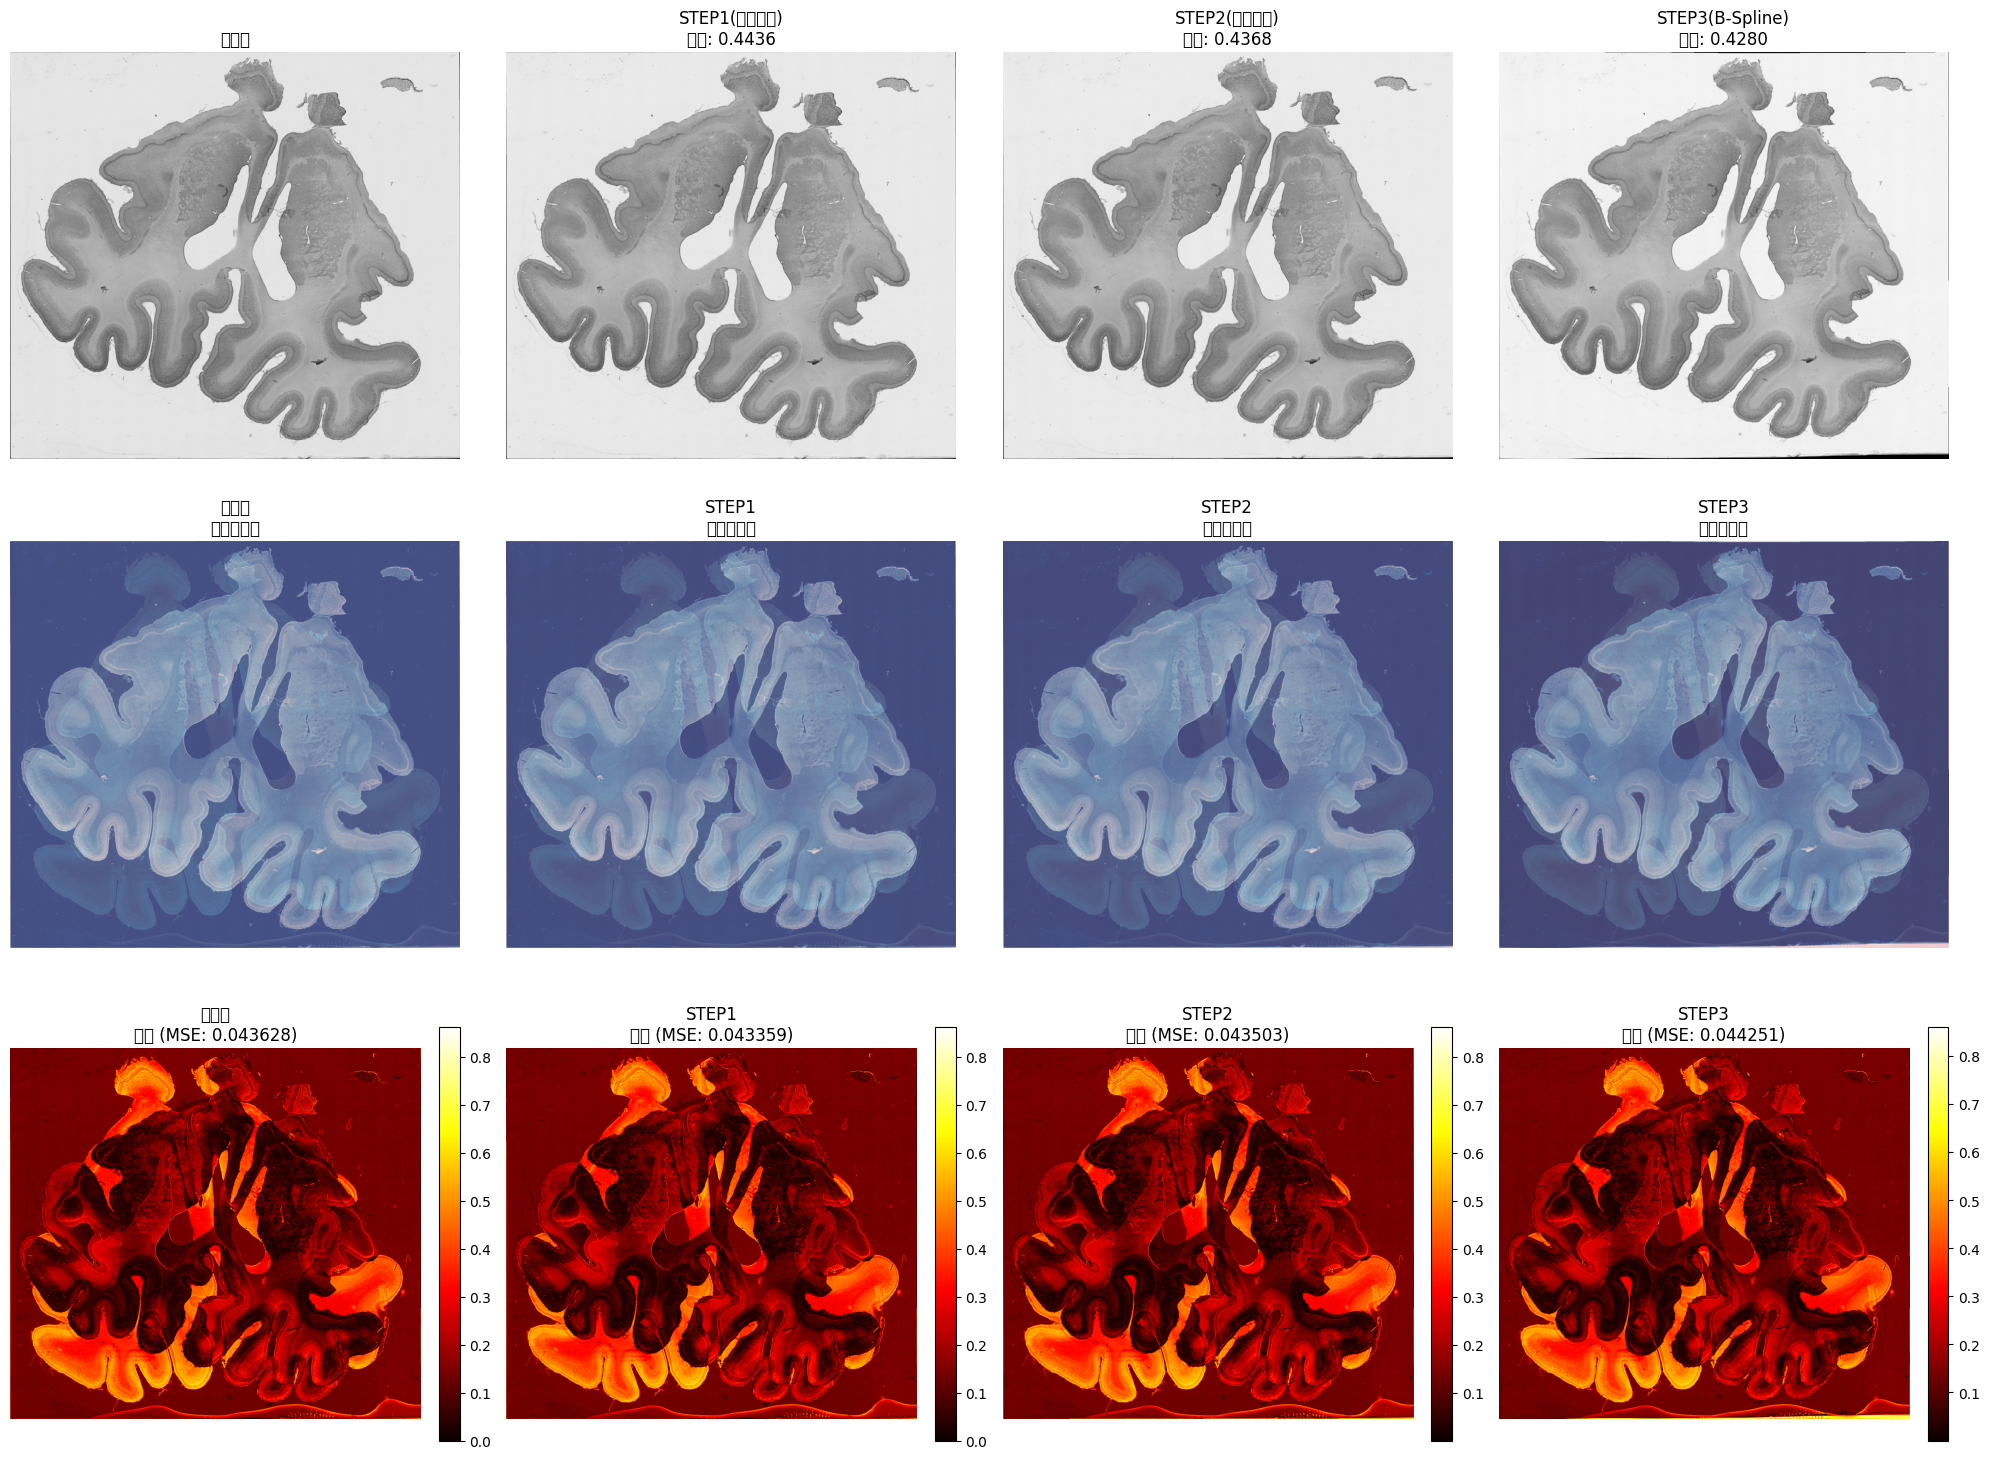


📈 相関係数の推移を表示...


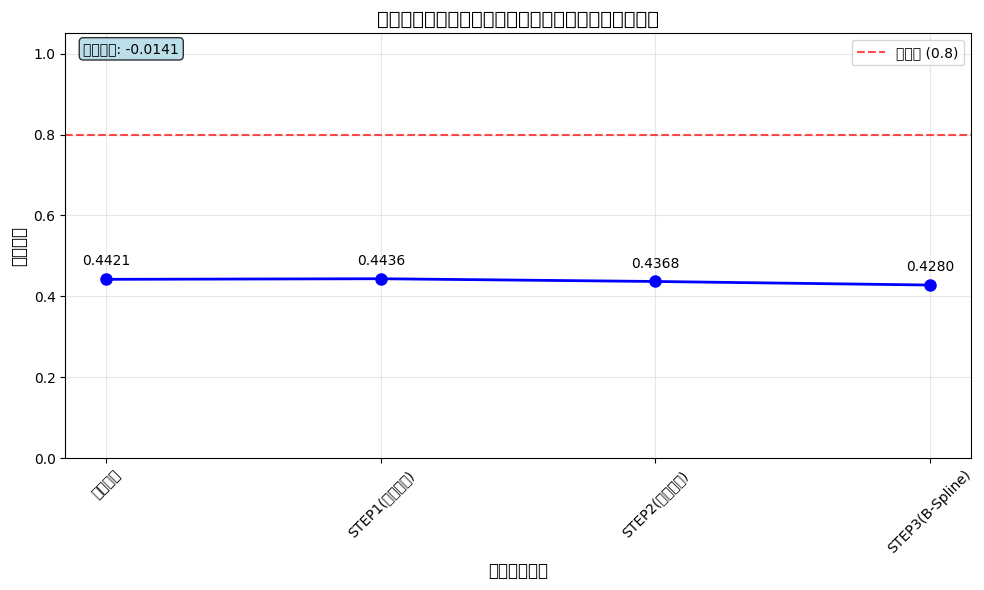


⏱️  各ステップの実行時間比較...


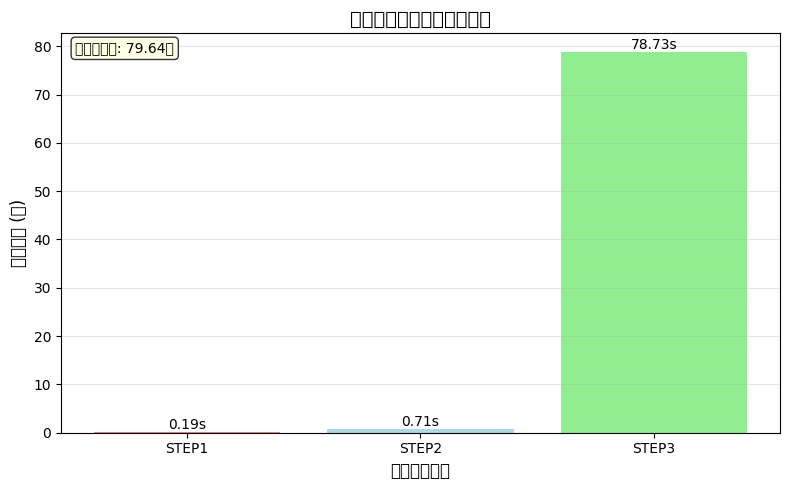

In [66]:
# 各ステップの結果比較可視化
print("🖼️  全ステップの結果を比較可視化中...")

# 利用可能な結果をチェック
available_results = []
step_names = []
step_data = []

# 各ステップの結果をチェック
if moving_np is not None:
    available_results.append(moving_np)
    step_names.append("原画像")
    step_data.append({"name": "原画像", "correlation": None})

if step1_result_np is not None:
    available_results.append(step1_result_np)
    step_names.append("STEP1")
    try:
        corr = np.corrcoef(fixed_np.flatten(), step1_result_np.flatten())[0, 1]
        step_data.append({"name": "STEP1(位相相関)", "correlation": corr})
    except:
        step_data.append({"name": "STEP1(位相相関)", "correlation": None})

if step2_result_np is not None:
    available_results.append(step2_result_np)
    step_names.append("STEP2")
    try:
        corr = np.corrcoef(fixed_np.flatten(), step2_result_np.flatten())[0, 1]
        step_data.append({"name": "STEP2(アフィン)", "correlation": corr})
    except:
        step_data.append({"name": "STEP2(アフィン)", "correlation": None})

if step3_result_np is not None:
    available_results.append(step3_result_np)
    step_names.append("STEP3")
    try:
        corr = np.corrcoef(fixed_np.flatten(), step3_result_np.flatten())[0, 1]
        step_data.append({"name": "STEP3(B-Spline)", "correlation": corr})
    except:
        step_data.append({"name": "STEP3(B-Spline)", "correlation": None})

if len(available_results) >= 2 and fixed_np is not None:
    n_results = len(available_results)
    
    # 3行の表示: 1) 個別結果, 2) 重ね合わせ, 3) 差分画像
    fig, axes = plt.subplots(3, n_results, figsize=(5*n_results, 15))
    
    if n_results == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (result_img, step_name, step_info) in enumerate(zip(available_results, step_names, step_data)):
        # 1行目: 個別結果画像
        axes[0, i].imshow(result_img, cmap='gray')
        title = f"{step_info['name']}"
        if step_info['correlation'] is not None:
            title += f"\n相関: {step_info['correlation']:.4f}"
        axes[0, i].set_title(title, fontsize=12)
        axes[0, i].axis('off')
        
        # 2行目: 固定画像との重ね合わせ
        axes[1, i].imshow(fixed_np, cmap='Reds', alpha=0.7)
        axes[1, i].imshow(result_img, cmap='Blues', alpha=0.7)
        axes[1, i].set_title(f"{step_name}\n重ね合わせ", fontsize=12)
        axes[1, i].axis('off')
        
        # 3行目: 差分画像
        diff_img = np.abs(fixed_np - result_img)
        im = axes[2, i].imshow(diff_img, cmap='hot')
        axes[2, i].set_title(f"{step_name}\n差分 (MSE: {np.mean(diff_img**2):.6f})", fontsize=12)
        axes[2, i].axis('off')
        
        # カラーバーを追加（差分画像のみ）
        plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # 相関係数の推移グラフ
    print("\n📈 相関係数の推移を表示...")
    
    correlations = []
    labels = []
    
    # 初期相関係数
    try:
        initial_corr = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
        correlations.append(initial_corr)
        labels.append("初期状態")
    except:
        pass
    
    # 各ステップの相関係数を追加
    for step_info in step_data[1:]:  # 原画像をスキップ
        if step_info['correlation'] is not None:
            correlations.append(step_info['correlation'])
            labels.append(step_info['name'])
    
    if len(correlations) >= 2:
        plt.figure(figsize=(10, 6))
        
        # 折れ線グラフ
        plt.plot(range(len(correlations)), correlations, 'bo-', linewidth=2, markersize=8)
        
        # 目標ライン
        plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='目標値 (0.8)')
        
        # データポイントに値を表示
        for i, (corr, label) in enumerate(zip(correlations, labels)):
            plt.annotate(f'{corr:.4f}', 
                        (i, corr), 
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center',
                        fontsize=10)
        
        plt.xlabel('処理ステップ', fontsize=12)
        plt.ylabel('相関係数', fontsize=12)
        plt.title('画像レジストレーション処理における相関係数の推移', fontsize=14)
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.ylim(0, 1.05)
        
        # 改善度の表示
        if len(correlations) >= 2:
            total_improvement = correlations[-1] - correlations[0]
            plt.text(0.02, 0.98, f'総改善度: {total_improvement:+.4f}', 
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # ステップ実行時間の比較（利用可能な場合）
    execution_times = []
    time_labels = []
    
    if 'step1_execution_time' in globals() and step1_execution_time is not None:
        execution_times.append(step1_execution_time)
        time_labels.append("STEP1")
    
    if step2_info and 'execution_time' in step2_info:
        execution_times.append(step2_info['execution_time'])
        time_labels.append("STEP2")
    
    if step3_info and 'execution_time' in step3_info:
        execution_times.append(step3_info['execution_time'])
        time_labels.append("STEP3")
    
    if execution_times:
        print("\n⏱️  各ステップの実行時間比較...")
        
        plt.figure(figsize=(8, 5))
        bars = plt.bar(time_labels, execution_times, color=['lightcoral', 'lightblue', 'lightgreen'][:len(execution_times)])
        
        # バーの上に時間を表示
        for bar, time_val in zip(bars, execution_times):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{time_val:.2f}s', ha='center', va='bottom', fontsize=10)
        
        plt.xlabel('処理ステップ', fontsize=12)
        plt.ylabel('実行時間 (秒)', fontsize=12)
        plt.title('各ステップの実行時間比較', fontsize=14)
        plt.grid(True, alpha=0.3, axis='y')
        
        total_time = sum(execution_times)
        plt.text(0.02, 0.98, f'総実行時間: {total_time:.2f}秒', 
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

else:
    print("❌ 比較可視化に十分な結果がありません")
    if fixed_np is None:
        print("   - 固定画像が読み込まれていません")
    if len(available_results) < 2:
        print(f"   - 利用可能な結果が不足しています ({len(available_results)}/2)")

## 7. 最終結果の可視化と評価指標の計算

最終的な位置合わせ結果を詳細に評価し、包括的な評価指標を計算します。

🏆 最終結果の包括的評価を実行中...
📊 最終採用手法: 3ステップ完全版 (位相相関→アフィン→B-Spline)

📈 包括的評価指標を計算中...
   相関係数: 0.428020
   平均二乗誤差 (MSE): 0.04425137
   PSNR: 13.54 dB
   相関係数: 0.428020
   平均二乗誤差 (MSE): 0.04425137
   PSNR: 13.54 dB
   SSIM: 0.595821
   SSIM: 0.595821
   正規化相互情報量 (NMI): 0.055728
   正規化相互情報量 (NMI): 0.055728
   エッジ保存度: 0.026457

🎯 目標達成度評価:
   ❌ 要改善 相関係数0.6未満 (0.4280)
   改善度: -0.0141 (-2.5%改善)

🖼️  最終結果の可視化...
   エッジ保存度: 0.026457

🎯 目標達成度評価:
   ❌ 要改善 相関係数0.6未満 (0.4280)
   改善度: -0.0141 (-2.5%改善)

🖼️  最終結果の可視化...


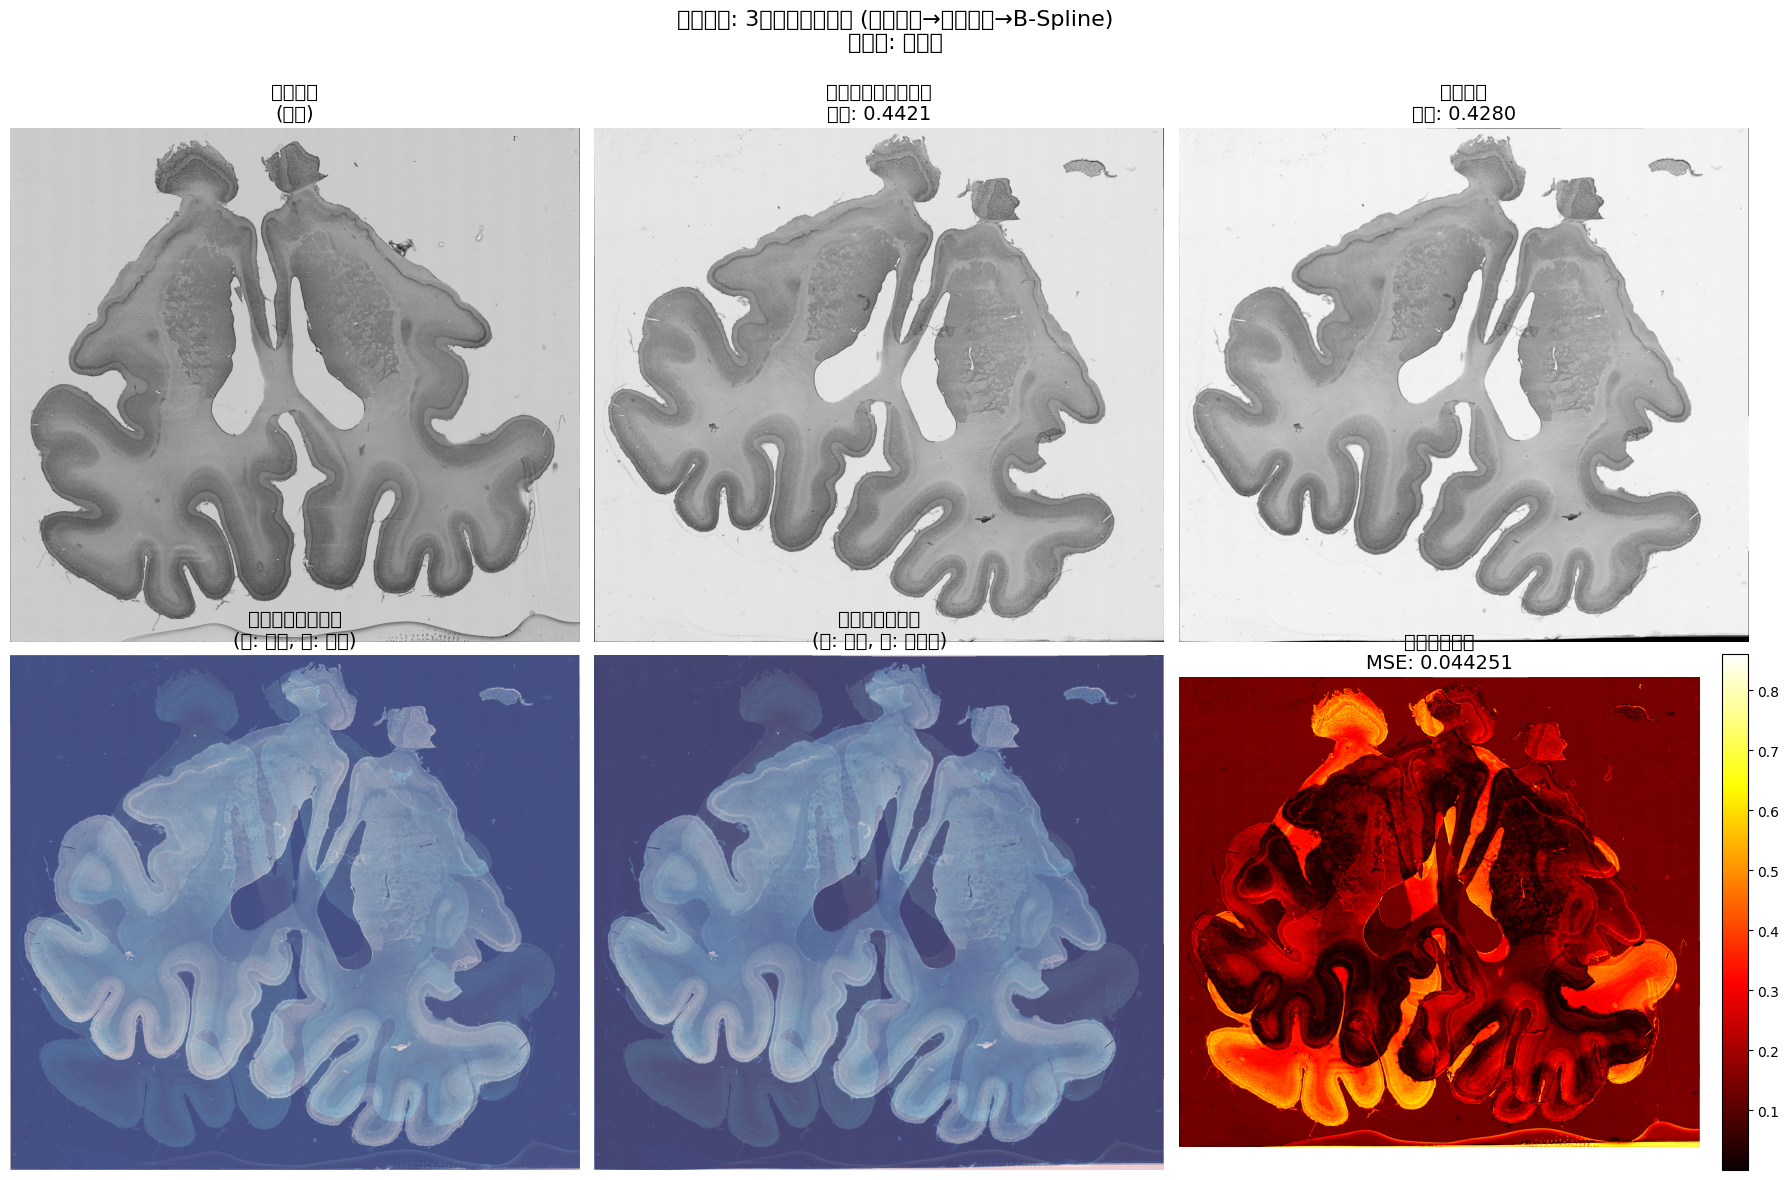


🔲 最終CheckerBoard比較...


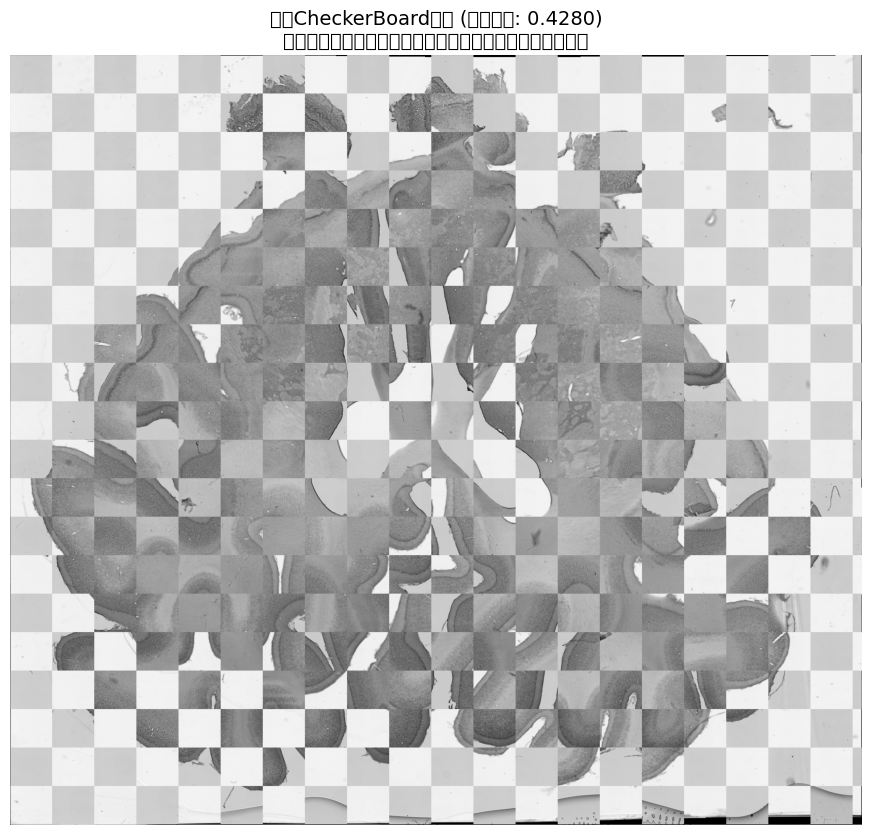


📋 評価指標サマリー:
   手法: 3ステップ完全版 (位相相関→アフィン→B-Spline)
   correlation: 0.428020 ❌
   mse: 0.04425137
   psnr: 13.54 dB
   ssim: 0.595821
   nmi: 0.055728
   edge_preservation: 0.026457

💾 結果画像を保存しました: pig_brain_registration_result_20250624_095452.png
💾 評価指標を保存しました: pig_brain_registration_metrics_20250624_095452.json
🎉 豚脳スライス画像の3段階レジストレーション処理が完了しました！

💾 結果画像を保存しました: pig_brain_registration_result_20250624_095452.png
💾 評価指標を保存しました: pig_brain_registration_metrics_20250624_095452.json
🎉 豚脳スライス画像の3段階レジストレーション処理が完了しました！


In [67]:
# 最終結果の包括的評価
print("🏆 最終結果の包括的評価を実行中...")
print("=" * 70)

# 最良の結果を選択
final_result_np = None
final_method_name = None
final_correlation = None

# ステップ3→2→1の順で最良結果を選択
if step3_result_np is not None:
    final_result_np = step3_result_np
    final_method_name = "3ステップ完全版 (位相相関→アフィン→B-Spline)"
elif step2_result_np is not None:
    final_result_np = step2_result_np
    final_method_name = "2ステップ版 (位相相関→アフィン)"
elif step1_result_np is not None:
    final_result_np = step1_result_np
    final_method_name = "1ステップ版 (位相相関のみ)"
else:
    print("❌ 利用可能な結果がありません")

if final_result_np is not None and fixed_np is not None:
    print(f"📊 最終採用手法: {final_method_name}")
    
    # 包括的評価指標の計算
    print("\n📈 包括的評価指標を計算中...")
    
    metrics = {}
    
    try:
        # 1. 相関係数（Pearson correlation coefficient）
        final_correlation = np.corrcoef(fixed_np.flatten(), final_result_np.flatten())[0, 1]
        metrics['correlation'] = final_correlation
        print(f"   相関係数: {final_correlation:.6f}")
        
        # 2. 平均二乗誤差 (MSE)
        mse = np.mean((fixed_np - final_result_np) ** 2)
        metrics['mse'] = mse
        print(f"   平均二乗誤差 (MSE): {mse:.8f}")
        
        # 3. ピーク信号対雑音比 (PSNR)
        if mse > 0:
            psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        else:
            psnr = float('inf')
        metrics['psnr'] = psnr
        print(f"   PSNR: {psnr:.2f} dB")
        
        # 4. 構造類似性指数 (SSIM)
        try:
            if 'ssim' in globals():
                ssim_value = ssim(fixed_np, final_result_np, data_range=1.0)
                metrics['ssim'] = ssim_value
                print(f"   SSIM: {ssim_value:.6f}")
            else:
                print("   SSIM: 計算不可 (scikit-imageが必要)")
        except Exception as e:
            print(f"   SSIM: 計算エラー ({e})")
        
        # 5. 正規化相互情報量 (NMI)
        try:
            # ヒストグラムベースの相互情報量計算
            fixed_int = (fixed_np * 255).astype(np.uint8)
            final_int = (final_result_np * 255).astype(np.uint8)
            
            hist_2d, _, _ = np.histogram2d(fixed_int.ravel(), final_int.ravel(), bins=256)
            
            # 相互情報量計算
            pxy = hist_2d / float(np.sum(hist_2d))
            px = np.sum(pxy, axis=1)
            py = np.sum(pxy, axis=0)
            px_py = px[:, None] * py[None, :]
            
            nzs = pxy > 0
            mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
            
            # エントロピー計算
            hx = -np.sum(px * np.log(px + 1e-10))
            hy = -np.sum(py * np.log(py + 1e-10))
            
            # 正規化相互情報量
            nmi = 2 * mi / (hx + hy)
            metrics['nmi'] = nmi
            print(f"   正規化相互情報量 (NMI): {nmi:.6f}")
            
        except Exception as e:
            print(f"   NMI: 計算エラー ({e})")
        
        # 6. エッジ保存度
        try:
            # Cannyエッジ検出
            fixed_edges = cv2.Canny((fixed_np * 255).astype(np.uint8), 50, 150)
            final_edges = cv2.Canny((final_result_np * 255).astype(np.uint8), 50, 150)
            
            # エッジの一致度
            edge_intersection = np.sum((fixed_edges > 0) & (final_edges > 0))
            edge_union = np.sum((fixed_edges > 0) | (final_edges > 0))
            
            if edge_union > 0:
                edge_preservation = edge_intersection / edge_union
            else:
                edge_preservation = 0
                
            metrics['edge_preservation'] = edge_preservation
            print(f"   エッジ保存度: {edge_preservation:.6f}")
            
        except Exception as e:
            print(f"   エッジ保存度: 計算エラー ({e})")
        
        # 評価サマリー
        print(f"\n🎯 目標達成度評価:")
        if final_correlation >= 0.8:
            print(f"   ✅ 目標達成！ 相関係数0.8+を達成 ({final_correlation:.4f})")
            achievement = "優秀"
        elif final_correlation >= 0.7:
            print(f"   🟡 良好な結果 相関係数0.7+ ({final_correlation:.4f})")
            achievement = "良好"
        elif final_correlation >= 0.6:
            print(f"   🟠 まずまずの結果 相関係数0.6+ ({final_correlation:.4f})")
            achievement = "まずまず"
        else:
            print(f"   ❌ 要改善 相関係数0.6未満 ({final_correlation:.4f})")
            achievement = "要改善"
        
        # 初期からの改善度
        try:
            initial_correlation = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
            total_improvement = final_correlation - initial_correlation
            improvement_percentage = (total_improvement / (1.0 - initial_correlation)) * 100
            
            print(f"   改善度: {total_improvement:+.4f} ({improvement_percentage:.1f}%改善)")
            
        except:
            print("   改善度: 計算不可")
        
        # 最終可視化
        print(f"\n🖼️  最終結果の可視化...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1行目
        # 固定画像
        axes[0, 0].imshow(fixed_np, cmap='gray')
        axes[0, 0].set_title('固定画像\n(基準)', fontsize=14)
        axes[0, 0].axis('off')
        
        # 移動画像（原画像）
        axes[0, 1].imshow(moving_np, cmap='gray')
        initial_corr = np.corrcoef(fixed_np.flatten(), moving_np.flatten())[0, 1]
        axes[0, 1].set_title(f'移動画像（処理前）\n相関: {initial_corr:.4f}', fontsize=14)
        axes[0, 1].axis('off')
        
        # 最終結果
        axes[0, 2].imshow(final_result_np, cmap='gray')
        axes[0, 2].set_title(f'最終結果\n相関: {final_correlation:.4f}', fontsize=14)
        axes[0, 2].axis('off')
        
        # 2行目
        # 処理前の重ね合わせ
        axes[1, 0].imshow(fixed_np, cmap='Reds', alpha=0.7)
        axes[1, 0].imshow(moving_np, cmap='Blues', alpha=0.7)
        axes[1, 0].set_title('処理前重ね合わせ\n(赤: 固定, 青: 移動)', fontsize=14)
        axes[1, 0].axis('off')
        
        # 最終重ね合わせ
        axes[1, 1].imshow(fixed_np, cmap='Reds', alpha=0.7)
        axes[1, 1].imshow(final_result_np, cmap='Blues', alpha=0.7)
        axes[1, 1].set_title('最終重ね合わせ\n(赤: 固定, 青: 補正後)', fontsize=14)
        axes[1, 1].axis('off')
        
        # 最終差分画像
        final_diff = np.abs(fixed_np - final_result_np)
        im = axes[1, 2].imshow(final_diff, cmap='hot')
        axes[1, 2].set_title(f'最終差分画像\nMSE: {mse:.6f}', fontsize=14)
        axes[1, 2].axis('off')
        plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)
        
        plt.suptitle(f'最終結果: {final_method_name}\n達成度: {achievement}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # CheckerBoard最終比較
        if 'sitk' in globals():
            try:
                print("\n🔲 最終CheckerBoard比較...")
                
                fixed_sitk_temp = sitk.GetImageFromArray(fixed_np)
                final_sitk_temp = sitk.GetImageFromArray(final_result_np)
                
                # より細かいCheckerBoard
                checkerboard = sitk.CheckerBoard(fixed_sitk_temp, final_sitk_temp, (20, 20))
                checkerboard_array = sitk.GetArrayFromImage(checkerboard)
                
                plt.figure(figsize=(12, 10))
                plt.imshow(checkerboard_array, cmap='gray')
                plt.title(f'最終CheckerBoard比較 (相関係数: {final_correlation:.4f})\n' + 
                         'チェッカーパターンの境界がスムーズなら位置合わせ成功', fontsize=14)
                plt.axis('off')
                plt.show()
                
            except Exception as e:
                print(f"❌ CheckerBoard表示エラー: {e}")
        
        # 評価指標のサマリー表示
        print(f"\n📋 評価指標サマリー:")
        print(f"   手法: {final_method_name}")
        for key, value in metrics.items():
            if value is not None:
                if key == 'correlation':
                    print(f"   {key}: {value:.6f} {'✅' if value >= 0.8 else '🟡' if value >= 0.7 else '❌'}")
                elif key == 'mse':
                    print(f"   {key}: {value:.8f}")
                elif key == 'psnr':
                    print(f"   {key}: {value:.2f} dB")
                else:
                    print(f"   {key}: {value:.6f}")
        
        # 結果の保存（オプション）
        save_results = True  # 必要に応じてFalseに変更
        
        if save_results:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                
                # 結果画像の保存
                result_filename = f"pig_brain_registration_result_{timestamp}.png"
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(fixed_np, cmap='gray')
                plt.title('固定画像')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(moving_np, cmap='gray')
                plt.title('移動画像（処理前）')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(final_result_np, cmap='gray')
                plt.title(f'最終結果\n相関: {final_correlation:.4f}')
                plt.axis('off')
                
                plt.tight_layout()
                plt.savefig(result_filename, dpi=300, bbox_inches='tight')
                plt.close()
                
                print(f"\n💾 結果画像を保存しました: {result_filename}")
                
                # メトリクスの保存
                import json
                metrics_filename = f"pig_brain_registration_metrics_{timestamp}.json"
                
                save_data = {
                    'timestamp': timestamp,
                    'method': final_method_name,
                    'achievement': achievement,
                    'metrics': {k: float(v) if v is not None else None for k, v in metrics.items()}
                }
                
                with open(metrics_filename, 'w', encoding='utf-8') as f:
                    json.dump(save_data, f, indent=2, ensure_ascii=False)
                
                print(f"💾 評価指標を保存しました: {metrics_filename}")
                
            except Exception as e:
                print(f"❌ 結果保存エラー: {e}")
                
    except Exception as e:
        print(f"❌ 評価計算でエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()
                
else:
    print("❌ 最終評価を実行できません。画像処理が正常に完了していません。")

print("=" * 70)
print("🎉 豚脳スライス画像の3段階レジストレーション処理が完了しました！")
print("=" * 70)

## まとめとトラブルシューティング

### 🎯 処理の成功基準
- **相関係数0.8以上**: 目標達成
- **相関係数0.7-0.8**: 良好な結果
- **相関係数0.6-0.7**: まずまずの結果
- **相関係数0.6未満**: 要改善

### 🔧 よくある問題と対処法

#### 1. ライブラリインポートエラー
```bash
pip install opencv-python SimpleITK matplotlib scikit-image scipy
```

#### 2. 画像読み込みエラー
- ファイルパスが正しいか確認
- 画像形式がサポートされているか確認（TIFF推奨）
- ファイルの読み取り権限があるか確認

#### 3. STEP 1（位相相関）で失敗
- 画像のコントラストを改善
- ノイズ除去の前処理を追加
- 位置ずれが極端に大きい場合は手動で大まかに位置を合わせる

#### 4. STEP 2（アフィン変換）で失敗
- 反復回数を増やす
- 学習率を調整
- サンプリング率を変更

#### 5. STEP 3（B-Spline変換）で失敗
- グリッドサイズを大きくする（8→12）
- B-Splineの次数を下げる（3→2）
- メモリ不足の場合は画像サイズを縮小

#### 6. 相関係数が改善しない
- 画像の品質（コントラスト、ノイズ）を確認
- 前処理方法を変更
- 異なるメトリクス（SSIM、NMI）も確認

### 📊 評価指標の説明
- **相関係数**: 画像の線形関係の強さ（-1から1、1に近いほど良い）
- **MSE**: 平均二乗誤差（0に近いほど良い）
- **PSNR**: ピーク信号対雑音比（高いほど良い）
- **SSIM**: 構造類似性指数（0から1、1に近いほど良い）
- **NMI**: 正規化相互情報量（0から1、1に近いほど良い）

### 🚀 パフォーマンス最適化のヒント
1. 画像サイズを適切に調整（大きすぎると遅い、小さすぎると精度低下）
2. マルチスケール処理で粗い→細かい調整
3. 適切なサンプリング率でメモリ使用量を制御
4. GPUが利用可能な環境ではGPU処理を検討

---
**注意**: このノートブックは豚脳スライス画像の高精度位置合わせを目的として設計されています。他の画像タイプに適用する場合は、パラメータの調整が必要な場合があります。